In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

In [2]:
granularity = 10

if granularity == 50:
    PATH = 'results_50'
    df = pd.read_csv("db_extract/df_indi_works.csv", index_col=0)
    df['decade'] = df['decade'].apply(lambda x: 50 * round(x / 50))
    df = df[df['decade']<=1850]
elif granularity == 10:
    PATH = 'results_10'
    df = pd.read_csv("db_extract/df_indi_works.csv", index_col=0)
    df['decade'] = df['decade'].apply(lambda x: 10 * round(x / 10))
    df = df[df['decade']<=1880]

original_df = df.copy()
original_df = original_df[['individual_wikidata_id', 'decade','region_name']].drop_duplicates()

len(set(df.individual_wikidata_id))


regions = pd.read_csv(
    "other_data/ENS - Cultural Index - Countries Databases - region_level.csv"
)

regions["region_name"][regions["region_name"] == "Slav world"] = "East Slavic"
regions = regions[regions["level"] == 2]
regions = regions[regions["region_name"] != "Balkans"]
regions = regions[
    regions["region_name"] != "Eastern Europe"
]  # remove because it takes East Slavic and Central Europe
regions = list(set(regions["region_name"]))

regions_add = ['Northwestern Europe', 
 'Southwestern Europe',
 'Southern Japan',
 'Northern Japan',
 'Northern China',
 'Southern China',
 'Ottoman Turkey',
 'Yangtze']

regions = regions + regions_add

df = df[df["region_name"].isin(regions)]

df["century"] = df["decade"].round(-2)
# Avoid overlapping with Antiquity

df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Portugal") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Spain") & (df["decade"] < 500))]
#df = df[~((df["region_name"] == "Arabic world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Balkans") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "France") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "United Kingdom") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Low countries") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "East Slavic") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Central Europe") & (df["decade"] < 500))]
#df = df[~((df["region_name"] == "Eastern Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "German world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Latin world") & (df["decade"] > 500))]

df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})

len(set(df_m.individual_wikidata_id))


df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})

# knots
sample = df_m.copy()
#sample = sample.sample(2000, random_state=42)

,region_name,count_works_f1_f2
0,Arabic world,1535.00
1,Central Europe,11144.00
2,Chinese world,1816.00
3,East Slavic,5032.00
4,France,22682.00
5,German world,39543.00
6,Greek World,1561.00
7,Indian world,510.00
8,Italy,16669.00
9,Japan,1546.00


In [31]:
df[df['region_name']=='Nordic countries'].sort_values('decade')

,individual_wikidata_id,decade,individual_name,score,region_name,count_works,century,count
77787,Q1402591,590,Ohthere,3,Nordic countries,0.00,600,0.00
100560,Q15661609,830,Brúni hvíti Háreksson,1,Nordic countries,0.00,800,0.00
246074,Q2628262,840,Hastein,5,Nordic countries,0.00,800,0.00
228818,Q2367169,840,Bragi Boddason,13,Nordic countries,0.00,800,0.00
123608,Q16782546,850,Þórólfur Þorsteinsson,1,Nordic countries,0.00,800,0.00
...,...,...,...,...,...,...,...,...
474454,Q6228296,1880,Jonas Wærn,2,Nordic countries,0.00,1900,0.00
474451,Q6228261,1880,Thorsten Waenerberg,10,Nordic countries,13.00,1900,13.00
121120,Q16650323,1880,Nils Selander,10,Nordic countries,0.00,1900,0.00
296343,Q31684815,1880,Alfvar Theodorik Segerdahl,1,Nordic countries,0.00,1900,0.00


In [32]:
min(df[df['region_name']=='Nordic countries'].decade)

590

In [33]:
#df[df['count']>3].to_csv('db_extract/df_indi__work>2.csv')

In [34]:
list(set(sample['region_name']))

['Northwestern Europe',
 'Persian world',
 'Korea',
 'Portugal',
 'Low countries',
 'Greek World',
 'East Slavic',
 'France',
 'Southern China',
 'United Kingdom',
 'Nordic countries',
 'Southwestern Europe',
 'Ottoman Turkey',
 'Indian world',
 'Yangtze',
 'Northern China',
 'Italy',
 'Japan',
 'German world',
 'Arabic world',
 'Northern Japan',
 'Spain',
 'Central Europe',
 'Southern Japan',
 'Chinese world',
 'Latin World']

In [35]:
len(set(df.individual_wikidata_id))

157140

### Compute the Generalized Chao and predict the sample

In [53]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
from tqdm import tqdm

# Assuming 'sample' is your original DataFrame
# Prepare the data
sample['decade_spline'] = pd.cut(sample['decade'], bins=10, labels=False)

In [28]:
# Define the formula
formula = "y ~ C(decade_spline) + C(region_name)"


# Number of bootstraps
n_bootstraps = 10
predicted_probs = []
aic_values = []  # List to store AIC values

for _ in tqdm(range(n_bootstraps)):
    # Create a bootstrap sample
    bootstrap_sample = sample.sample(n=len(sample), replace=True)
    
    # Fit the model to the bootstrap sample
    model = smf.logit(formula=formula, data=bootstrap_sample).fit(disp=0)

    
    # Store AIC value
    aic_values.append(model.aic)
    
    # Predict probabilities and store
    predicted_prob = model.predict(sample)
    predicted_probs.append(predicted_prob)

# Calculate average AIC over all bootstrap samples
average_aic = np.mean(aic_values)
print(f"Average AIC from all bootstrap samples: {average_aic}")

# Convert list of predictions to DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs).T

# Calculate the mean of y values for each observation
sample['y_mean'] = predicted_probs_df.mean(axis=1)

# Calculate the 2.5th and 97.5th percentiles for each observation
confidence_interval = predicted_probs_df.apply(lambda x: np.percentile(x, [2.5, 97.5]), axis=1)

# Add the confidence intervals to the original sample DataFrame
sample['y_min'], sample['y_max'] = confidence_interval.str[0], confidence_interval.str[1]


 10%|█         | 1/10 [00:02<00:23,  2.62s/it]/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
 20%|██        | 2/10 [00:06<00:25,  3.16s/it]/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 30%|███       | 3/10 [00:12<00:32,  4.58s/it]/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

Average AIC from all bootstrap samples: 87935.66890364831


In [ ]:
# Create a new DataFrame with the original data and predictions
results_df = sample[['individual_wikidata_id', 'decade', 'region_name', 'y', 'y_mean', 'y_min', 'y_max']].copy()

# Compute f0, f1, and f2
def compute_f0(p):
    l = (2 * p) / (1 - p)
    f0 = 1 / (l + (l**2) / 2)
    return f0

def compute_f1(y):
    return 1 if y == 0 else 0

def compute_f2(y):
    return 1 if y == 1 else 0

results_df['f0'] = results_df['y_mean'].apply(compute_f0)
results_df['f1'] = results_df['y'].apply(compute_f1)
results_df['f2'] = results_df['y'].apply(compute_f2)

# Calculate N_unseen, N_unseen_min, and N_unseen_max
results_df['N_unseen'] = results_df['f0'] + results_df['f1'] + results_df['f2']
results_df['N_unseen'] = results_df['N_unseen'].astype(int)

results_df['f0_min'] = results_df['y_max'].apply(compute_f0)
results_df['f0_max'] = results_df['y_min'].apply(compute_f0)

results_df['N_unseen_min'] = (results_df['f0_min'] + results_df['f1'] + results_df['f2']).astype(int)
results_df['N_unseen_max'] = (results_df['f0_max'] + results_df['f1'] + results_df['f2']).astype(int)

results_df

,individual_wikidata_id,decade,region_name,y,y_mean,y_min,y_max,f0,f1,f2,N_unseen,f0_min,f0_max,N_unseen_min,N_unseen_max
0,Q1000034,1850,German world,0,0.03,0.03,0.03,16.53,1,0,17,15.39,17.47,16,18
2,Q1000034,1850,Northwestern Europe,0,0.04,0.04,0.05,10.37,1,0,11,10.11,10.59,11,11
5,Q100022441,1770,France,0,0.06,0.06,0.06,7.72,1,0,8,7.57,8.12,8,9
6,Q100022441,1770,Northwestern Europe,0,0.04,0.04,0.05,10.37,1,0,11,10.11,10.59,11,11
9,Q100028706,1880,Italy,0,0.04,0.03,0.04,12.76,1,0,13,11.88,13.64,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584297,Q99982212,1880,Central Europe,0,0.02,0.02,0.02,22.78,1,0,23,20.14,26.14,21,27
584303,Q999920,1790,German world,1,0.03,0.03,0.03,16.53,0,1,17,15.39,17.47,16,18
584304,Q999920,1790,Northwestern Europe,1,0.04,0.04,0.05,10.37,0,1,11,10.11,10.59,11,11
584306,Q999983,1340,France,0,0.06,0.05,0.06,8.08,1,0,9,7.64,8.67,8,9


In [ ]:
results_df.to_csv('unseen_species_model/unseen_species_model_no_occupation.csv')

### Run without North and South

In [ ]:
granularity = 10

if granularity == 50:
    PATH = 'results_50'
    df = pd.read_csv("db_extract/df_indi_works.csv", index_col=0)
    df['decade'] = df['decade'].apply(lambda x: 50 * round(x / 50))
    df = df[df['decade']<=1850]
elif granularity == 10:
    PATH = 'results_10'
    df = pd.read_csv("db_extract/df_indi_works.csv", index_col=0)
    df['decade'] = df['decade'].apply(lambda x: 10 * round(x / 10))
    df = df[df['decade']<=1880]

original_df = df.copy()
original_df = original_df[['individual_wikidata_id', 'decade','region_name']].drop_duplicates()

len(set(df.individual_wikidata_id))


regions = pd.read_csv(
    "other_data/ENS - Cultural Index - Countries Databases - region_level.csv"
)

regions["region_name"][regions["region_name"] == "Slav world"] = "East Slavic"
regions = regions[regions["level"] == 2]
regions = regions[regions["region_name"] != "Balkans"]
regions = regions[
    regions["region_name"] != "Eastern Europe"
]  # remove because it takes East Slavic and Central Europe
regions = list(set(regions["region_name"]))


df = df[df["region_name"].isin(regions)]

df["century"] = df["decade"].round(-2)
# Avoid overlapping with Antiquity

df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Portugal") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Spain") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Arabic world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Balkans") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "France") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "United Kingdom") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Low countries") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "East Slavic") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Central Europe") & (df["decade"] < 500))]
#df = df[~((df["region_name"] == "Eastern Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "German world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Latin world") & (df["decade"] > 500))]

df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})

len(set(df_m.individual_wikidata_id))


df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})

# knots
sample = df_m.copy()
#sample = sample.sample(2000, random_state=42)

In [ ]:
# Assuming 'sample' is your original DataFrame
# Prepare the data
sample['decade_spline'] = pd.cut(sample['decade'], bins=10, labels=False)

In [ ]:


# Define the formula
formula = "y ~ C(decade_spline) + C(region_name)"


# Number of bootstraps
n_bootstraps = 10
predicted_probs = []
aic_values = []  # List to store AIC values

for _ in tqdm(range(n_bootstraps)):
    # Create a bootstrap sample
    bootstrap_sample = sample.sample(n=len(sample), replace=True)
    
    # Fit the model to the bootstrap sample
    model = smf.logit(formula=formula, data=bootstrap_sample).fit(disp=0)

    
    # Store AIC value
    aic_values.append(model.aic)
    
    # Predict probabilities and store
    predicted_prob = model.predict(sample)
    predicted_probs.append(predicted_prob)

# Calculate average AIC over all bootstrap samples
average_aic = np.mean(aic_values)
print(f"Average AIC from all bootstrap samples: {average_aic}")

# Convert list of predictions to DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs).T

# Calculate the mean of y values for each observation
sample['y_mean'] = predicted_probs_df.mean(axis=1)

# Calculate the 2.5th and 97.5th percentiles for each observation
confidence_interval = predicted_probs_df.apply(lambda x: np.percentile(x, [2.5, 97.5]), axis=1)

# Add the confidence intervals to the original sample DataFrame
sample['y_min'], sample['y_max'] = confidence_interval.str[0], confidence_interval.str[1]


 40%|████      | 4/10 [00:06<00:09,  1.60s/it]/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 60%|██████    | 6/10 [00:10<00:07,  1.96s/it]/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 90%|█████████ | 9/10 [00:17<00:01,  1.93s/it]/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


Average AIC from all bootstrap samples: 46641.83788997665


#### Make summary table

In [ ]:
# Create a new DataFrame with the original data and predictions
results_df = sample[['individual_wikidata_id', 'decade', 'region_name', 'y', 'y_mean', 'y_min', 'y_max']].copy()

In [ ]:
# Compute f0, f1, and f2
def compute_f0(p):
    l = (2 * p) / (1 - p)
    f0 = 1 / (l + (l**2) / 2)
    return f0

def compute_f1(y):
    return 1 if y == 0 else 0

def compute_f2(y):
    return 1 if y == 1 else 0

results_df['f0'] = results_df['y_mean'].apply(compute_f0)
results_df['f1'] = results_df['y'].apply(compute_f1)
results_df['f2'] = results_df['y'].apply(compute_f2)

# Calculate N_unseen, N_unseen_min, and N_unseen_max
results_df['N_unseen'] = results_df['f0'] + results_df['f1'] + results_df['f2']
results_df['N_unseen'] = results_df['N_unseen'].astype(int)

results_df['f0_min'] = results_df['y_max'].apply(compute_f0)
results_df['f0_max'] = results_df['y_min'].apply(compute_f0)

results_df['N_unseen_min'] = (results_df['f0_min'] + results_df['f1'] + results_df['f2']).astype(int)
results_df['N_unseen_max'] = (results_df['f0_max'] + results_df['f1'] + results_df['f2']).astype(int)

# Group by region_name and compute statistics
region_stats = results_df.groupby('region_name').agg({
    'individual_wikidata_id': 'count',
    'f1': 'sum',
    'f2': 'sum',
    'f0': 'sum'
}).rename(columns={
    'individual_wikidata_id': 'N_original',
    'f0': 'f0'
})

# Calculate the number of individuals with more than 2 works (f>2)
df_more_3_works = df[df['count_works'] > 2].drop_duplicates(subset=['individual_wikidata_id'], keep='first')
df_more_3_works = df_more_3_works.groupby('region_name')['individual_wikidata_id'].nunique()
region_stats['f>2'] = df_more_3_works.values

# Merge with count_works data
region_stats = region_stats.merge(df_count_work_model, on='region_name', how='left')
region_stats['N_original'] = region_stats['N_original'] + region_stats['f>2']


# Calculate count_works_all
region_stats['count_works_all'] = df_m.groupby('region_name')['count_works'].sum().values
# Calculate the sum of all data
region_stats_total = region_stats.sum(numeric_only=True).astype(int)


# Add the total row at the end of the table
region_stats_total['region_name'] = 'Total'
region_stats = pd.concat([region_stats, region_stats_total.to_frame().T])


region_stats['f0'] = region_stats['f0'].astype(int)
#region_stats['completeness'] = region_stats['f1'] / region_stats['count_works_all']
region_stats['coverage'] = region_stats['N_original'] / (region_stats['f0'] + region_stats['N_original'])
region_stats = region_stats.drop(columns=['count_works_f1_f2'])

region_stats['N_unseen'] = region_stats['f1'] + region_stats['f2'] + region_stats['f0'] + region_stats['f>2']
region_stats

,region_name,N_original,f1,f2,f0,f>2,count_works_all,coverage,N_unseen
0,Arabic world,1545,1225,84,9950,236,339.00,0.13,11495
1,Central Europe,11756,10678,233,246083,845,1149.00,0.05,257839
2,Chinese world,2220,1554,131,10414,535,576.00,0.18,12634
3,East Slavic,5413,4770,131,86247,512,634.00,0.06,91660
4,France,25248,20202,1240,162721,3806,5368.00,0.13,187969
5,German world,41561,37357,1093,634974,3111,4666.00,0.06,676535
6,Greek World,1630,1419,71,16051,140,377.00,0.09,17681
7,Indian world,556,436,37,2591,83,153.00,0.18,3147
8,Italy,18126,15517,576,211210,2033,2599.00,0.08,229336
9,Japan,1710,1390,78,12707,242,336.00,0.12,14417


### Plot Summary table for occupation (probability of finding a doubleton)

In [ ]:
# Extract model summary
summary = model.summary()
# Extract coefficients and confidence intervals
coef_df = summary.tables[1]

# Convert to pandas DataFrame for easier manipulation
coef_df = pd.DataFrame(coef_df.data[1:], columns=coef_df.data[0])
coef_df = coef_df.reset_index()
coef_df = coef_df.rename(columns={'':'variable'})
coef_df['variable'] = coef_df['variable'].astype(str)




### Plot the probability of finding a doubleton for different regions

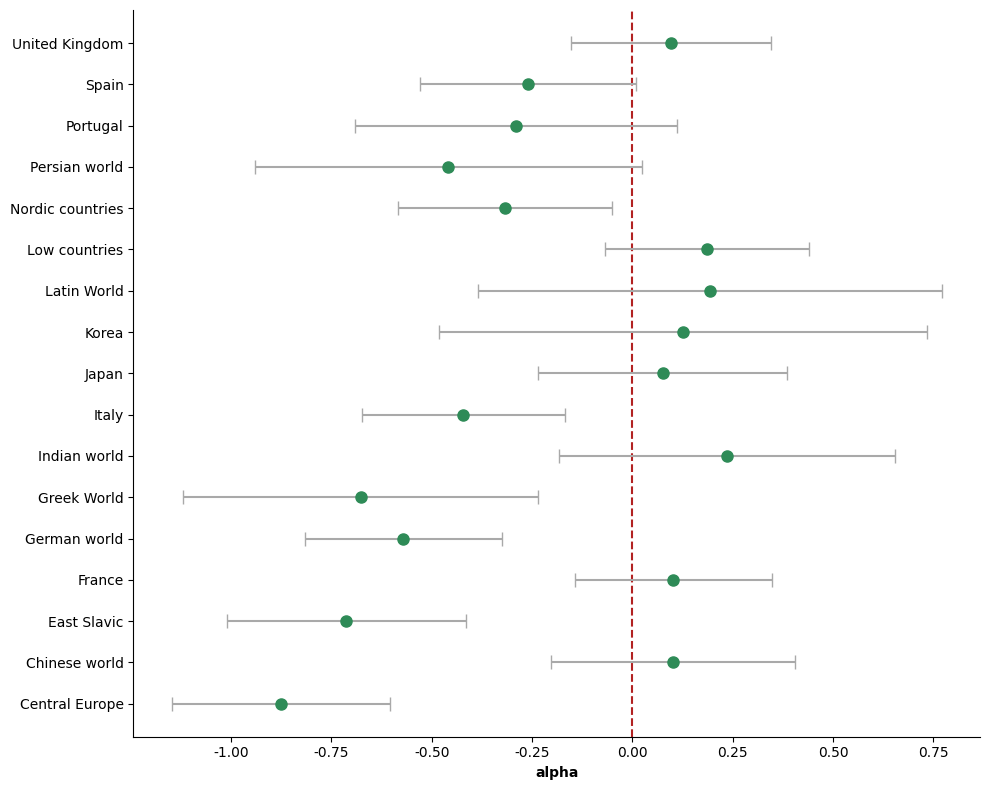

In [ ]:

# Now do the same for countries
country_coefs = coef_df[coef_df['variable'].str.contains('region_name')]

# Prepare data for plotting
country_data = {
    'country': country_coefs['variable'].str.replace('C(region_name)[T.', '').str.replace(']', ''),
    'coef': country_coefs['coef'].astype(float),
    'lower': country_coefs['[0.025'].astype(float),
    'upper': country_coefs['0.975]'].astype(float)
}

# Create forest plot for countries
fig, ax = plt.subplots(figsize=(10, 8))  # Increased figure size for more countries

# Plot the data points and error bars
ax.errorbar(country_data['coef'], country_data['country'], 
            xerr=[country_data['coef'] - country_data['lower'], 
                  country_data['upper'] - country_data['coef']],
            fmt='o', capsize=5, ecolor='darkgray', markersize=8, 
            color='seagreen', linewidth=1.5, zorder=2)

# Add a vertical line at x=0
ax.axvline(x=0, color='firebrick', linestyle='--', linewidth=1.5, zorder=1)

# Customize the plot
ax.set_xlabel('alpha', fontweight='bold')
ax.set_ylabel('', fontweight='bold')
ax.set_title('', fontsize=16, fontweight='bold')

# Adjust the x-axis to show more precision
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Plot the probabily in time for the Chinese world

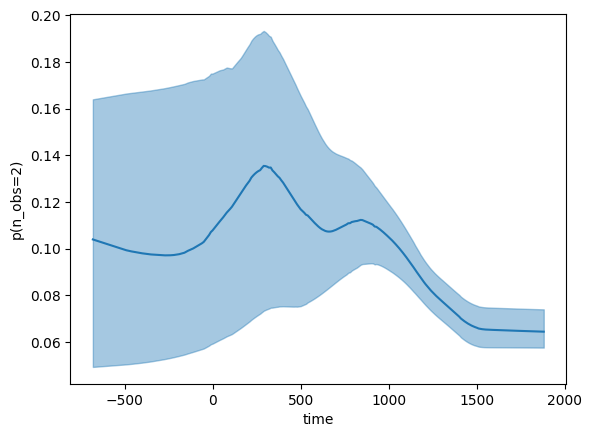

In [ ]:
data_f2 = results_df[['region_name', 'decade', 'y_mean', 'y_min', 'y_max']].copy()
data_f2 = data_f2.groupby(['region_name', 'decade'])[['y_mean', 'y_min', 'y_max']].mean().reset_index()
data_f2 = data_f2.groupby(['region_name', 'decade'])[['y_mean', 'y_min','y_max']].sum().reset_index()

data_f2_filtered = data_f2[data_f2['region_name']=='Chinese world']

fig, ax = plt.subplots()

frac = 0.3
# Plot predicted line with a LOWESS curve
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed_y = lowess(data_f2_filtered['y_mean'], data_f2_filtered['decade'], is_sorted=True, frac=frac)
ax.plot(smoothed_y[:, 0], smoothed_y[:, 1], color='C0', label='Predicted Line')

# Plot credibility bands with a LOWESS curve
smoothed_y_min = lowess(data_f2_filtered['y_min'], data_f2_filtered['decade'], is_sorted=True, frac=frac)
smoothed_y_max = lowess(data_f2_filtered['y_max'], data_f2_filtered['decade'], is_sorted=True, frac=frac)
ax.fill_between(smoothed_y_min[:, 0], smoothed_y_min[:, 1], smoothed_y_max[:, 1], alpha=0.4, color='C0', label='Credibility Bands')

ax.set(xlabel="time", ylabel="p(n_obs=2)")
ax.legend().remove()

### Plot test for Chinese world

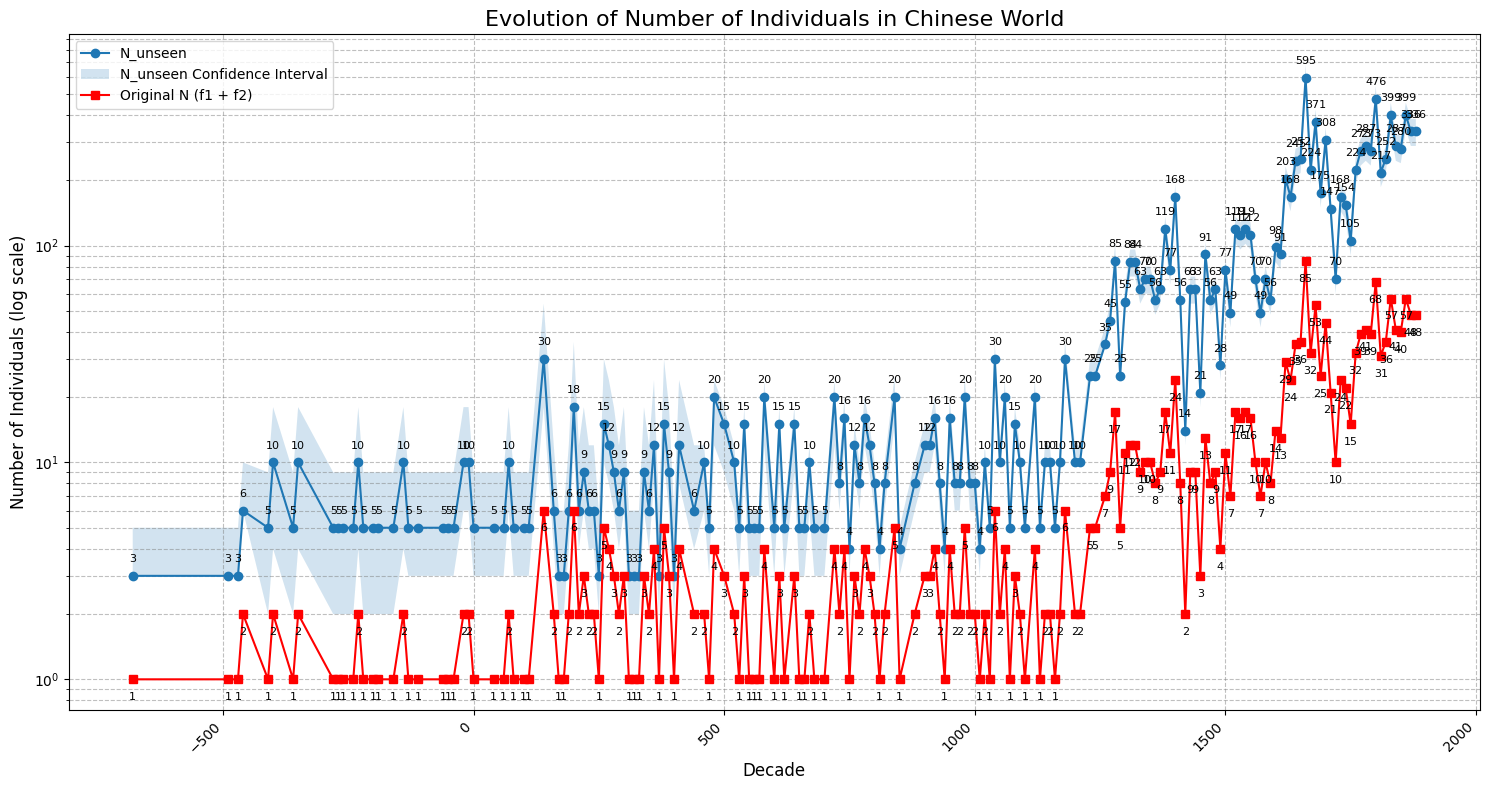

     decade  N_unseen  N_unseen_min  N_unseen_max  f1  f2   N
0      -680         3             3             5   1   0   1
1      -490         3             3             5   1   0   1
2      -470         3             3             5   1   0   1
3      -460         6             6            10   2   0   2
4      -410         5             2             9   0   1   1
..      ...       ...           ...           ...  ..  ..  ..
184    1840       287           246           328  40   1  41
185    1850       280           240           320  37   3  40
186    1860       399           342           456  55   2  57
187    1870       336           288           384  46   2  48
188    1880       336           288           384  46   2  48

[189 rows x 7 columns]


In [ ]:
# Filter data for Chinese world
chinese_world_data = results_df[results_df['region_name'] == 'Chinese world']
# Group by decade and calculate the sum of N_unseen, N_unseen_min, N_unseen_max, f1, and f2
# Also count the number of individual_wikidata_id as N
chinese_world_by_decade = chinese_world_data.groupby('decade').agg({
    'N_unseen': 'sum',
    'N_unseen_min': 'sum',
    'N_unseen_max': 'sum',
    'f1': 'sum',
    'f2': 'sum',
    'individual_wikidata_id': 'count'  # Count unique individuals
}).reset_index()



# Rename the count of individual_wikidata_id to N
chinese_world_by_decade = chinese_world_by_decade.rename(columns={'individual_wikidata_id': 'N'})


# Sort by decade
chinese_world_by_decade = chinese_world_by_decade.sort_values('decade')


# Create the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Plot N_unseen with confidence interval
plt.plot(chinese_world_by_decade['decade'], chinese_world_by_decade['N_unseen'], marker='o', label='N_unseen')
plt.fill_between(chinese_world_by_decade['decade'], 
                 chinese_world_by_decade['N_unseen_min'], 
                 chinese_world_by_decade['N_unseen_max'], 
                 alpha=0.2, label='N_unseen Confidence Interval')

# Plot original N (f1 + f2)
plt.plot(chinese_world_by_decade['decade'], chinese_world_by_decade['N'], marker='s', label='Original N (f1 + f2)', color='red')

plt.title('Evolution of Number of Individuals in Chinese World', fontsize=16)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Individuals (log scale)', fontsize=12)
plt.grid(True, which="both", ls="--", c='gray', alpha=0.5)
plt.legend(fontsize=10)

# Set y-axis to log scale
plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels to the points
for i, row in chinese_world_by_decade.iterrows():
    plt.annotate(f"{int(row['N_unseen'])}", 
                 (row['decade'], row['N_unseen']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=8)
    plt.annotate(f"{int(row['N'])}", 
                 (row['decade'], row['N']),
                 textcoords="offset points",
                 xytext=(0,-15),
                 ha='center',
                 fontsize=8)

plt.tight_layout()
plt.show()

# Display the data
print(chinese_world_by_decade)
